In [3]:
import pandas as pd
from pandas import datetime
from sklearn.metrics import mean_squared_error
import math
import random
import time
import numpy
import numpy as np
from scipy.linalg import pinv2
import matplotlib.pyplot as plt
import scipy.stats as stats

def parser(x):
    return datetime.strptime(x,"%Y-%m-%d")
#CHANGE FILE NAME HERE
data = pd.read_csv('Intermediate_Store1.csv', header = 0, parse_dates=[0],index_col=0,squeeze=True, date_parser=parser)
numpy.random.seed(1)

data = numpy.array(data)
data = numpy.reshape(data, (-1, 1))
data

C:\Users\koush\anaconda3\envs\LSBU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


array([[1316],
       [1264],
       [1305],
       ...,
       [2116],
       [2304],
       [2388]], dtype=int64)

In [5]:
class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual = []
        self.convergence = []
        self.optimizer = ""
        self.objfname = ""
        self.startTime = 0
        self.endTime = 0
        self.executionTime = 0
        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.popnum = 0
        self.maxiers = 0
        
def HHO(objf, lb, ub, dim, SearchAgents_no, Max_iter):

    # dim=30
    # SearchAgents_no=50
    # lb=-100
    # ub=100
    # Max_iter=500

    # initialize the location and Energy of the rabbit
    Rabbit_Location = numpy.zeros(dim)
    Rabbit_Energy = float("inf")  # change this to -inf for maximization problems

    if not isinstance(lb, list):
        lb = [lb for _ in range(dim)]
        ub = [ub for _ in range(dim)]
    lb = numpy.asarray(lb)
    ub = numpy.asarray(ub)

    # Initialize the locations of Harris' hawks
    X = numpy.asarray(
        [x * (ub - lb) + lb for x in numpy.random.uniform(0, 1, (SearchAgents_no, dim))]
    )

    # Initialize convergence
    convergence_curve = numpy.zeros(Max_iter)

    ############################
    s = solution()

    print('HHO is now tackling  "' + objf.__name__ + '"')

    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    ############################

    t = 0  # Loop counter

    # Main loop
    while t < Max_iter:
        for i in range(0, SearchAgents_no):

            # Check boundries

            X[i, :] = numpy.clip(X[i, :], lb, ub)

            # fitness of locations
            fitness = objf(X[i, :])

            # Update the location of Rabbit
            if fitness < Rabbit_Energy:  # Change this to > for maximization problem
                Rabbit_Energy = fitness
                Rabbit_Location = X[i, :].copy()

        E1 = 2 * (1 - (t / Max_iter))  # factor to show the decreaing energy of rabbit

        # Update the location of Harris' hawks
        for i in range(0, SearchAgents_no):

            E0 = 2 * random.random() - 1  # -1<E0<1
            Escaping_Energy = E1 * (
                E0
            )  # escaping energy of rabbit Eq. (3) in the paper

            # -------- Exploration phase Eq. (1) in paper -------------------

            if abs(Escaping_Energy) >= 1:
                # Harris' hawks perch randomly based on 2 strategy:
                q = random.random()
                rand_Hawk_index = math.floor(SearchAgents_no * random.random())
                X_rand = X[rand_Hawk_index, :]
                if q < 0.5:
                    # perch based on other family members
                    X[i, :] = X_rand - random.random() * abs(
                        X_rand - 2 * random.random() * X[i, :]
                    )

                elif q >= 0.5:
                    # perch on a random tall tree (random site inside group's home range)
                    X[i, :] = (Rabbit_Location - X.mean(0)) - random.random() * (
                        (ub - lb) * random.random() + lb
                    )

            # -------- Exploitation phase -------------------
            elif abs(Escaping_Energy) < 1:
                # Attacking the rabbit using 4 strategies regarding the behavior of the rabbit

                # phase 1: ----- surprise pounce (seven kills) ----------
                # surprise pounce (seven kills): multiple, short rapid dives by different hawks

                r = random.random()  # probablity of each event

                if (
                    r >= 0.5 and abs(Escaping_Energy) < 0.5
                ):  # Hard besiege Eq. (6) in paper
                    X[i, :] = (Rabbit_Location) - Escaping_Energy * abs(
                        Rabbit_Location - X[i, :]
                    )

                if (
                    r >= 0.5 and abs(Escaping_Energy) >= 0.5
                ):  # Soft besiege Eq. (4) in paper
                    Jump_strength = 2 * (
                        1 - random.random()
                    )  # random jump strength of the rabbit
                    X[i, :] = (Rabbit_Location - X[i, :]) - Escaping_Energy * abs(
                        Jump_strength * Rabbit_Location - X[i, :]
                    )

                # phase 2: --------performing team rapid dives (leapfrog movements)----------

                if (
                    r < 0.5 and abs(Escaping_Energy) >= 0.5
                ):  # Soft besiege Eq. (10) in paper
                    # rabbit try to escape by many zigzag deceptive motions
                    Jump_strength = 2 * (1 - random.random())
                    X1 = Rabbit_Location - Escaping_Energy * abs(
                        Jump_strength * Rabbit_Location - X[i, :]
                    )
                    X1 = numpy.clip(X1, lb, ub)

                    if objf(X1) < fitness:  # improved move?
                        X[i, :] = X1.copy()
                    else:  # hawks perform levy-based short rapid dives around the rabbit
                        X2 = (
                            Rabbit_Location
                            - Escaping_Energy
                            * abs(Jump_strength * Rabbit_Location - X[i, :])
                            + numpy.multiply(numpy.random.randn(dim), Levy(dim))
                        )
                        X2 = numpy.clip(X2, lb, ub)
                        if objf(X2) < fitness:
                            X[i, :] = X2.copy()
                if (
                    r < 0.5 and abs(Escaping_Energy) < 0.5
                ):  # Hard besiege Eq. (11) in paper
                    Jump_strength = 2 * (1 - random.random())
                    X1 = Rabbit_Location - Escaping_Energy * abs(
                        Jump_strength * Rabbit_Location - X.mean(0)
                    )
                    X1 = numpy.clip(X1, lb, ub)

                    if objf(X1) < fitness:  # improved move?
                        X[i, :] = X1.copy()
                    else:  # Perform levy-based short rapid dives around the rabbit
                        X2 = (
                            Rabbit_Location
                            - Escaping_Energy
                            * abs(Jump_strength * Rabbit_Location - X.mean(0))
                            + numpy.multiply(numpy.random.randn(dim), Levy(dim))
                        )
                        X2 = numpy.clip(X2, lb, ub)
                        if objf(X2) < fitness:
                            X[i, :] = X2.copy()

        convergence_curve[t] = Rabbit_Energy
        if t % 1 == 0:
            print(
                [
                    "At iteration "
                    + str(t)
                    + " the best fitness is "
                    + str(Rabbit_Energy)
                ]
            )
        t = t + 1

    timerEnd = time.time()
    s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime = timerEnd - timerStart
    s.convergence = convergence_curve
    s.optimizer = "HHO"
    s.objfname = objf.__name__
    s.best = Rabbit_Energy
    s.bestIndividual = Rabbit_Location

    return s


def Levy(dim):
    beta = 1.5
    sigma = (
        math.gamma(1 + beta)
        * math.sin(math.pi * beta / 2)
        / (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))
    ) ** (1 / beta)
    u = 0.01 * numpy.random.randn(dim) * sigma
    v = numpy.random.randn(dim)
    zz = numpy.power(numpy.absolute(v), (1 / beta))
    step = numpy.divide(u, zz)
    return step

def objective(hyperparams):
        
        n,lags,w_lo,w_hi,b_lo,b_hi = hyperparams
        m= int(lags)
        per = (1736 - m)/1826
        size = int(len(data) * per)
        d_train, d_test = data[0:size], data[size:len(data)]

        mean_train = np.mean(d_train)
        sd_train = np.std(d_train)
        d_train = (d_train-mean_train)/sd_train
        d_test = (d_test-mean_train)/sd_train
        X_train = np.array([d_train[i][0] for i in range(m)])
        y_train = np.array(d_train[m][0])

        for i in range(1,(d_train.shape[0]-m)):
            l = np.array([d_train[j][0] for j in range(i,i+m)])
            X_train = np.vstack([X_train,l])
            y_train = np.vstack([y_train,d_train[i+m]])
    
        #auto corrected input vector for test
        X_test = np.array([d_test[i][0] for i in range(m)])
        y_test = np.array(d_test[m][0])

        for i in range(1,(d_test.shape[0]-m)):
            l = np.array([d_test[j][0] for j in range(i,i+m)])
            X_test = np.vstack([X_test,l])
            y_test = np.vstack([y_test,d_test[i+m]])
            
        input_size = X_train.shape[1]
        hidden_size = int(n)   #no. of hidden neurons
        mu, sigma = 0, 1
         #initialising input weights and biases randomly drawn from a truncated normal distribution
        input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
        biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
        
        def relu(x):      #hidden layer activation function
            return np.maximum(x, 0, x)
        
        def hidden_nodes(X):
            G = np.dot(X, input_weights)
            G = G + biases
            H = relu(G)
            return H

        output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

        def predict(X):
            out = hidden_nodes(X)
            out = np.dot(out, output_weights)
            return out

        prediction = predict(X_test)

        # evaluate forecasts
        rmse = math.sqrt(mean_squared_error(y_test, prediction))
    
        return rmse
    
solver = HHO(objective, [1,1,-5,0.5,-5,0.5], [1826,275,-0.5,5,-0.5,5], 6, 15,500)

HHO is now tackling  "objective"
['At iteration 0 the best fitness is 0.2128815842866188']


In [8]:
solver.bestIndividual

array([536.36911265, 176.48181481,  -1.40186921,   1.59964915,
        -2.06230667,   3.00415875])

In [13]:
np.random.seed(1)

def parser(x):
    return datetime.strptime(x,"%Y-%m-%d")

#CHANGE FILE NAME HERE
data = pd.read_csv('Intermediate_Store1.csv', header = 0, parse_dates=[0],index_col=0,squeeze=True, date_parser=parser)
data = np.array(data)
data = np.reshape(data, (-1, 1))
#splitting data into test and train parts, Forecasting demand for last 3 months, (have to consider 3 months + m days to account for input features)
m= int(solver.bestIndividual[1])
per = (1736 - m)/1826
size = int(len(data) * per)
d_train, d_test = data[0:size], data[size:len(data)]

mean_train = np.mean(d_train)
sd_train = np.std(d_train)
d_train = (d_train-mean_train)/sd_train
d_test = (d_test-mean_train)/sd_train

# Converting data into 2d array combining time steps for directly feeding into ELM

#auto corrected input vector for training (we are taking m lagged values as features for each data point)
X_train = np.array([d_train[i][0] for i in range(m)])
y_train = np.array(d_train[m][0])

for i in range(1,(d_train.shape[0]-m)):
    l = np.array([d_train[j][0] for j in range(i,i+m)])
    X_train = np.vstack([X_train,l])
    y_train = np.vstack([y_train,d_train[i+m]])
    
#auto corrected input vector for test
X_test = np.array([d_test[i][0] for i in range(m)])
y_test = np.array(d_test[m][0])

for i in range(1,(d_test.shape[0]-m)):
    l = np.array([d_test[j][0] for j in range(i,i+m)])
    X_test = np.vstack([X_test,l])
    y_test = np.vstack([y_test,d_test[i+m]])
    
best_score, best_input_weights,best_biases = float("inf"), None,None

for i in range(1,100):
    input_size = X_train.shape[1]
    hidden_size = int(solver.bestIndividual[0])   #no. of hidden neurons

    w_lo = solver.bestIndividual[2]
    w_hi = solver.bestIndividual[3]
    b_lo = solver.bestIndividual[4]
    b_hi = solver.bestIndividual[5]
    mu, sigma = 0, 1
    #initialising input weights and biases randomly drawn from a truncated normal distribution
    input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
    biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
    
    def relu(x):      #hidden layer activation function
        return np.maximum(x, 0, x)
    def step(x):
        return np.heaviside(x, 1)
    
    def sigmoid(x):
        return 1/(1+np.exp(-x))    
    
    def gaussian(x):
        return np.exp(-(x*x))
    
    def arctangent(x):
        return np.arctan(x)
    
    def tanh(x):
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    
    def hidden_nodes(X):
        G = np.dot(X, input_weights)
        G = G + biases
        H = relu(G)
        return H

    output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

    def predict(X):
        out = hidden_nodes(X)
        out = np.dot(out, output_weights)
        return out

    prediction = predict(X_test)
    total = X_test.shape[0]
    
    # evaluate forecasts
    rmse = math.sqrt(mean_squared_error(y_test, prediction))
    print('Test RMSE: %.3f' % rmse)
    mape_sum = 0
    for i,j in zip(y_test,prediction):
        mape_sum = mape_sum + (abs((i-j)/i))
    mape = (mape_sum/total)*100
    mpe_sum = 0
    for i,j in zip(y_test,prediction):
        mpe_sum = mpe_sum + ((i-j)/i)
    mpe = (mpe_sum/total)*100
    print('Test MAPE: %.3f' % mape)
    print('Test MPE: %.3f' % mpe)
    if rmse < best_score:
        best_score, best_input_weights,best_biases = rmse, input_weights,biases
        
print("Best RMSE = ",best_score)

Test RMSE: 0.230
Test MAPE: 61.046
Test MPE: 6.592
Test RMSE: 0.224
Test MAPE: 73.733
Test MPE: -3.043
Test RMSE: 0.210
Test MAPE: 64.739
Test MPE: 31.797
Test RMSE: 0.227
Test MAPE: 60.326
Test MPE: 17.275
Test RMSE: 0.209
Test MAPE: 61.180
Test MPE: 10.990
Test RMSE: 0.212
Test MAPE: 62.144
Test MPE: 23.928
Test RMSE: 0.225
Test MAPE: 86.482
Test MPE: 49.351
Test RMSE: 0.236
Test MAPE: 66.829
Test MPE: 29.291
Test RMSE: 0.218
Test MAPE: 101.695
Test MPE: 53.268
Test RMSE: 0.237
Test MAPE: 86.307
Test MPE: 40.213
Test RMSE: 0.199
Test MAPE: 62.514
Test MPE: 28.552
Test RMSE: 0.221
Test MAPE: 61.626
Test MPE: 29.830
Test RMSE: 0.221
Test MAPE: 69.560
Test MPE: 31.821
Test RMSE: 0.212
Test MAPE: 62.731
Test MPE: 1.932
Test RMSE: 0.228
Test MAPE: 66.297
Test MPE: 14.803
Test RMSE: 0.224
Test MAPE: 54.485
Test MPE: 9.128
Test RMSE: 0.220
Test MAPE: 69.063
Test MPE: 8.103
Test RMSE: 0.204
Test MAPE: 54.768
Test MPE: 3.933
Test RMSE: 0.226
Test MAPE: 54.066
Test MPE: -3.124
Test RMSE: 0.206

Test RMSE: 764328400.772
Test MAPE: 100.000
Test MPE: 100.000


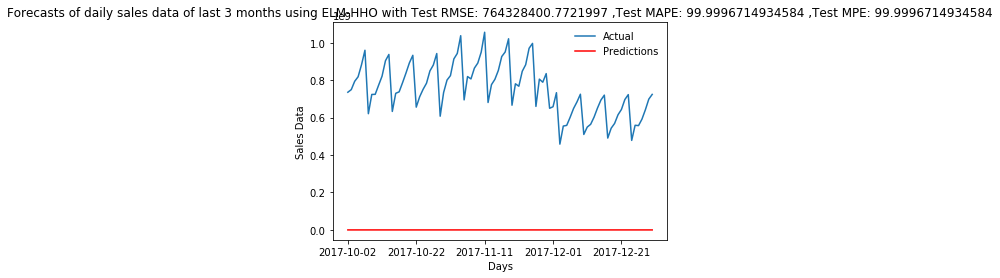

In [16]:
#Making forecasts with best ELM possible


#initialising input weights and biases randomly drawn from a Gaussian distribution
input_weights = best_input_weights
biases = best_biases

def relu(x):      #hidden layer activation function
    return np.maximum(x, 0, x)
def step(x):
    return np.heaviside(x, 1)    
def sigmoid(x):
    return 1/(1+np.exp(-x))
def gaussian(x):
    return np.exp(-(x*x))
def arctangent(x):
    return np.arctan(x)
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

prediction = predict(X_test)
total = X_test.shape[0]

y_test = (y_test*sd_train) + mean_train
prediction = (prediction*sd_train) + mean_train

# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, prediction))
print('Test RMSE: %.3f' % rmse)
mape_sum = 0
for i,j in zip(y_test,prediction):
    mape_sum = mape_sum + (abs((i-j)/i))
mape = (mape_sum/total)*100
mpe_sum = 0
for i,j in zip(y_test,prediction):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/total)*100
print('Test MAPE: %.3f' % mape)
print('Test MPE: %.3f' % mpe)

# plot forecasts against actual outcomes
fig, ax = plt.subplots()
ax.plot(y_test,label = 'Actual')
ax.plot(prediction, color='red',label = 'Predictions')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Days')
plt.ylabel('Sales Data')
plt.title('ELM-HHO with Test RMSE: '+str(rmse)+ ' ,Test MAPE: '+str(mape[0])+' ,Test MPE: '+str(mpe[0]))
plt.xticks([0,20,40,60,80],['2017-10-02','2017-10-22','2017-11-11','2017-12-01','2017-12-21'])
plt.savefig('ELM-HHO plot of Store1.png')  #CHANGE STORE NUMBER HERE